Split Anotations and images

In [1]:
import os
import shutil

# Download from Roboflow
# from roboflow import Roboflow
# rf = Roboflow(api_key="")
# project = rf.workspace("augmented-startups").project("vehicle-registration-plates-trudk")
# dataset = project.version(1).download("voc")

# Define the source folder containing JPG and XML files
source_folder = 'data/roboflow/train'

# Define the destination folders
images_folder = 'data/roboflow/images'
annotations_folder = 'data/roboflow/annotations'

# Ensure the destination folders exist; create them if they don't
os.makedirs(images_folder, exist_ok=True)
os.makedirs(annotations_folder, exist_ok=True)

# Loop through files in the source folder
for filename in os.listdir(source_folder):
    # Check if the file is a JPG image
    if filename.lower().endswith('.jpg'):
        source_file_path = os.path.join(source_folder, filename)
        destination_file_path = os.path.join(images_folder, filename)
        # Move the JPG file to the images folder
        shutil.move(source_file_path, destination_file_path)
    # Check if the file is an XML annotation file
    elif filename.lower().endswith('.xml'):
        source_file_path = os.path.join(source_folder, filename)
        destination_file_path = os.path.join(annotations_folder, filename)
        # Move the XML file to the annotations folder
        shutil.move(source_file_path, destination_file_path)

print("Separation completed.")

Separation completed.


## Training Dataset Preprocessing

In [2]:
import os
import cv2
import pathlib
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import torchvision.transforms.v2 as v2
import torch.nn as nn
import torch.nn.functional as F

TESTING_IMAGES_SIZE = 0.1

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_imgs(data):
    """
    Display multiple images with bounding boxes.
    
    Parameters:
    - data: A list of lists. Each inner list contains:
        [title, image, original_bbox, predicted_bbox]
    """
    
    num_imgs = len(data)
    fig, axes = plt.subplots(1, num_imgs, figsize=(15, 5 * num_imgs))
    
    # If there's only one image, axes won't be a list, so we wrap it in a list for consistency
    if num_imgs == 1:
        axes = [axes]
    
    for ax, (title, image, orig_bbox, pred_bbox) in zip(axes, data):
        # Handle torch.Tensor
        if isinstance(image, torch.Tensor):
            if image.is_cuda:
                image = image.cpu()  # Move tensor to CPU if it's on CUDA

            if image.dim() == 4:  # If a batch of images
                image = image[0]  # Take the first image

            img = image.detach().permute(1, 2, 0).numpy()  # permute to HWC layout
        # Handle PIL.Image
        elif isinstance(image, Image.Image):
            img = np.array(image)
        else:
            img = image.copy()

        # If the image values are between 0 and 1, scale them to [0, 255]
        # If the image values are between 0 and 1, scale them to [0, 255]
        if isinstance(img, np.ndarray) and img.max() <= 1.0:
            img = img * 255
            
        ax.imshow(img.astype(int), cmap='gray' if len(img.shape) == 2 or img.shape[2] == 1 else None)

        # Draw the original bounding box
        x, y, x1, y1 = orig_bbox
        if isinstance(orig_bbox, torch.Tensor):
            x, y, x1, y1 = orig_bbox.cpu().numpy()
        rect_orig = patches.Rectangle((x, y), x1 - x, y1 - y, linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect_orig)

        # Draw the predicted bounding box
        x, y, x1, y1 = pred_bbox
        if isinstance(pred_bbox, torch.Tensor):
            x, y, x1, y1 = pred_bbox.cpu().numpy()
        rect_pred = patches.Rectangle((x, y), x1 - x, y1 - y, linewidth=2, edgecolor='y', facecolor='none')
        ax.add_patch(rect_pred)

        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()



class LPR_Training_Dataset_Processed():
    IMAGE_PATH = "data/roboflow/images/"
    ANNOTATION_PATH = "data/roboflow/annotations/"

    training_data = []
    testing_data = []

    def create_training_data(self):
        self.img_list = os.listdir(self.IMAGE_PATH)
        testing_size = len(self.img_list) * TESTING_IMAGES_SIZE

        i = 0
        for a in tqdm(range(max(2000, len(self.img_list)))):
            img_data = self.img_list[a]
            img_path = os.path.join(self.IMAGE_PATH, img_data)
            annotation_path = os.path.join(self.ANNOTATION_PATH, img_data.replace('.jpg', '.xml')) # get required image annotations
            with Image.open(img_path).convert("L") as img:
                with open(annotation_path) as source:
                    root = ET.parse(source).getroot()
                    
                    # Iterate through the XML and extract bounding box coordinates
                    for obj in root.findall('.//object'):
                        bndbox = obj.find('bndbox')
                        xmin = int(bndbox.find('xmin').text)
                        ymin = int(bndbox.find('ymin').text)
                        xmax = int(bndbox.find('xmax').text)
                        ymax = int(bndbox.find('ymax').text)
                    
                    bounding_box_coordinates = (xmin, ymin, xmax, ymax) # resize bounding box to fit resized image
                    
                    if (i < testing_size):
                        #self.testing_data.append([torch.Tensor(np.asarray(img)).view(-1, 416, 416) / 255, torch.Tensor(bounding_box_coordinates)])
                        self.testing_data.append([np.asarray(img), bounding_box_coordinates])
                    else:
                        self.training_data.append([np.asarray(img), bounding_box_coordinates])
                        #self.training_data.append([torch.Tensor(np.asarray(img)).view(-1, 416, 416) / 255, torch.Tensor(bounding_box_coordinates)])
            i += 1

        np.random.shuffle(self.training_data)
        print(f"Training Images: {len(self.training_data)}")
        print(f"Testing Images: {len(self.testing_data)}")

training_dataset = LPR_Training_Dataset_Processed()
training_dataset.create_training_data()


100%|██████████| 8823/8823 [00:12<00:00, 709.90it/s]

Training Images: 7940
Testing Images: 883


## Model Definition

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LPLocalNet(nn.Module):
    def __init__(self):
        super(LPLocalNet, self).__init__()

        # CNNs for grayscale images
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5)
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=192, kernel_size=5)

        # Connecting CNN outputs with Fully Connected layers for bounding box
        self.box_fc1 = nn.Linear(in_features=12288, out_features=240)
        self.box_fc2 = nn.Linear(in_features=240, out_features=120)
        self.box_out = nn.Linear(in_features=120, out_features=4)

    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv5(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=4, stride=2)

        t = torch.flatten(t, start_dim=1)

        box_t = self.box_fc1(t)
        box_t = F.relu(box_t)

        box_t = self.box_fc2(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_out(box_t)
       

        return box_t

## Get data and split between test and training data

7146
794


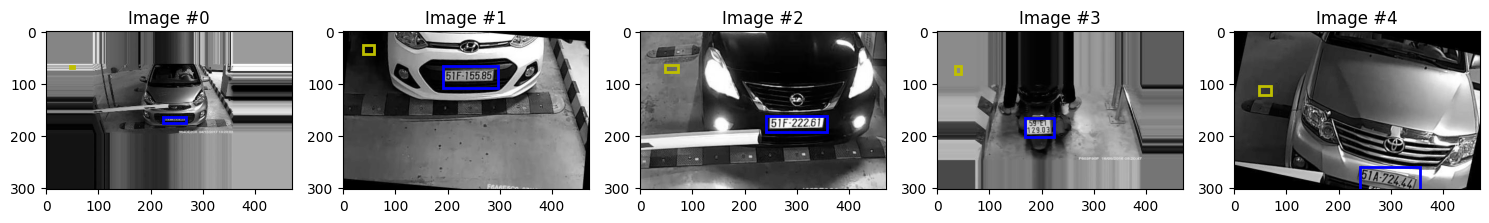

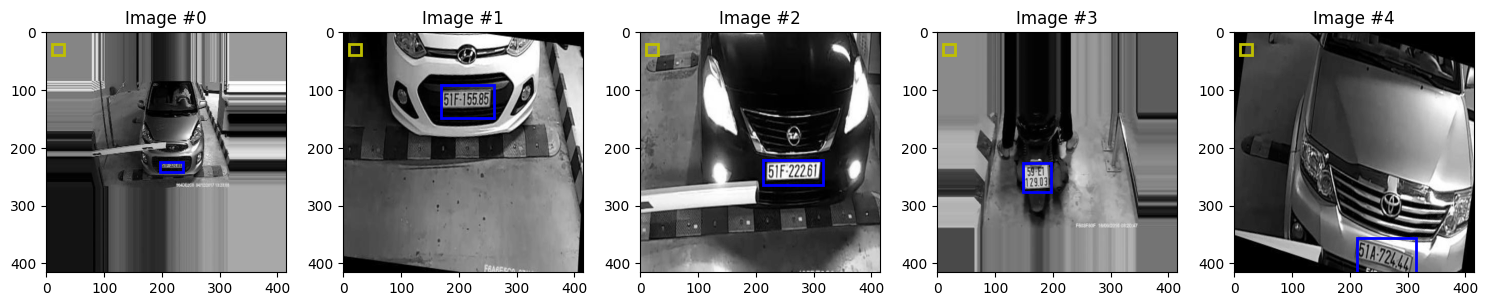

In [4]:
from PIL import Image
resized_images = [Image.fromarray(i[0]) for i in training_dataset.training_data]
numpy_data = np.array([np.array(img.resize((416, 416))) for img in resized_images])
X = torch.Tensor(numpy_data)

X = X / 255.0

numpy_bbox = np.array([
    ([416/resized_images[i].width, 416/resized_images[i].height, 416/resized_images[i].width, 416/resized_images[i].height] * np.array(data[1])) for i, data in enumerate(training_dataset.training_data)])
y = torch.Tensor(numpy_bbox)

VAL_PCT = 0.1 # percent of data we want to use for testing vs training
val_size = int(len(X) * VAL_PCT)

# create test and training splits
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

demo_arr = []
for i in range(5):
    demo_arr.append(["Image #{}".format(i), Image.fromarray(training_dataset.training_data[i][0]), np.array(training_dataset.training_data[i][1]), [0.2, 0.4, 0.2, 0.4] * np.array(training_dataset.training_data[i][1])])
show_imgs(demo_arr)
demo_arr = []
for i in range(5):
    orig_img = Image.fromarray(training_dataset.training_data[i][0])
    demo_arr.append(["Image #{}".format(i), numpy_data[i], numpy_bbox[i], [10, 20, 30, 40]])
show_imgs(demo_arr)



## Train!

In [5]:
# Imports
import time
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from jupyterplot import ProgressPlot

# BATCH_SIZE memory requirements:
#   - 250 approx eq. 6.6 GB (fine on secondary 8GB VRAM GPU)
#   - 200 approx eq. 5.5 GB
#   - 100 approx eq. 2.6 GB
#   - 50  approx eq. 1.3 GB

# LOSS_ABANDON:
#   -0.2 , abandons training when loss change % average is higher than this
#    0   , will disable

# Constants
BATCH_SIZE = 300
EPOCHS = 700
LEARNING_RATE = 0.001
PRELOAD_ALL_DATA_TO_GPU = False
LOSS_ABANDON = 0

# Helper function to convert seconds to hours, minutes, seconds format
def seconds_to_hms(seconds):
    h, remainder = divmod(seconds, 3600)
    m, s = divmod(remainder, 60)
    return "{:02}:{:02}:{:02}".format(int(h), int(m), int(s))

# Set device for training
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize neural network and transfer to device
net = LPLocalNet().to(device)
print("Running", net.__class__.__name__ ,"on", device)

# Set optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
loss_function = nn.MSELoss()

# Preloading data to GPU if required
if (PRELOAD_ALL_DATA_TO_GPU):
    train_X_gpu = train_X.to(device)
    train_y_gpu = train_y.to(device)
    dataset = TensorDataset(train_X_gpu, train_y_gpu)
else:
    dataset = TensorDataset(train_X, train_y)

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Training preparation
net.train()
pp = ProgressPlot(
    plot_names=["Training Loss over Epochs"],
    line_names=["loss"],
    x_label="Epochs",
)
avg_epoch_duration = None
start_loss_plot = 2
last_loss = []
loss_simple = 1
loss_pc_history = []
cumulative_loss = torch.zeros(1, device=device)
batch_count = 0
final_epoch = 0

print(f"The above loss plot will start from Epoch #{start_loss_plot} onwards, to enhance readability.")
print("Waiting 2s before starting training...")
time.sleep(2)
start_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    for batch_X, batch_y in loader:  #tqdm(loader, unit="batch"):
        if (PRELOAD_ALL_DATA_TO_GPU):
            batch_X = batch_X.view(-1, 1, 416, 416)
        else:
            batch_X = batch_X.to(device).view(-1, 1, 416, 416)
            batch_y = batch_y.to(device)

        # This removes bad data, but should probably try fix it instead!
        if (batch_y.shape[0] == 0):
            continue

        optimizer.zero_grad(set_to_none=True)
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

        cumulative_loss += loss
        batch_count += 1

    loss_simple = (cumulative_loss / batch_count).item()
    cumulative_loss = torch.zeros(1, device=device)
    batch_count = 0

    if len(loss_pc_history) > start_loss_plot:
        pp.update(loss_simple)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    avg_epoch_duration = epoch_duration if epoch == 0 else (avg_epoch_duration + epoch_duration) / 2

    if len(last_loss) > 0:
        loss_diff = -(100 - (loss_simple / last_loss[-1] * 100))
    else:
        loss_diff = 0

    last_loss.append(loss_simple)
    loss_pc_history.append(loss_diff)
    avg_loss_trend = sum(loss_pc_history[-15:]) / 15 if len(loss_pc_history) >= 15 else sum(loss_pc_history) / len(loss_pc_history)
    completion_time = seconds_to_hms((EPOCHS - epoch - 1) * avg_epoch_duration)

    print(f"Epoch #{str(epoch).ljust(3)} - Loss: {loss_simple:.3f} - Loss Diff: {loss_diff:.3f}% - Loss Trend: {avg_loss_trend:.3f} - Complete in: {completion_time}s")

    if (LOSS_ABANDON != 0 and avg_loss_trend > LOSS_ABANDON and not avg_loss_trend == 0):
        print("--- LOSS TREND TOO HIGH ---")
        print(f"Abandoning training at Epoch #{epoch}")
        break

    final_epoch = epoch

# Training completion
end_time = time.time()
total_duration = end_time - start_time
print("Total training time: {:.2f} seconds".format(total_duration))
pp.finalize()


Running LPLocalNet on cuda:0


The above loss plot will start from Epoch #2 onwards, to enhance readability.
Waiting 2s before starting training...
Epoch #0   - Loss: 22525.465 - Loss Diff: 0.000% - Loss Trend: 0.000 - Complete in: 02:06:55s
Epoch #1   - Loss: 3724.079 - Loss Diff: -83.467% - Loss Trend: -41.734 - Complete in: 02:05:03s
Epoch #2   - Loss: 3037.932 - Loss Diff: -18.425% - Loss Trend: -33.964 - Complete in: 02:04:02s
Epoch #3   - Loss: 2794.354 - Loss Diff: -8.018% - Loss Trend: -27.477 - Complete in: 02:03:25s
Epoch #4   - Loss: 2493.840 - Loss Diff: -10.754% - Loss Trend: -24.133 - Complete in: 02:03:06s
Epoch #5   - Loss: 2264.174 - Loss Diff: -9.209% - Loss Trend: -21.646 - Complete in: 02:02:44s
Epoch #6   - Loss: 2015.485 - Loss Diff: -10.984% - Loss Trend: -20.122 - Complete in: 02:02:28s
Epoch #7   - Loss: 1865.710 - Loss Diff: -7.431% - Loss Trend: -18.536 - Complete in: 02:02:13s
Epoch #8   - Loss: 1734.556 - Loss Diff: -7.030% - Loss Trend: -17.258 - Complete in: 02:01:59s
Epoch #9   - Loss

  4%|▍         | 33/794 [00:00<00:02, 330.00it/s]

torch.Size([4]) torch.Size([416, 416])
torch.Size([4]) torch.Size([416, 416])
torch.Size([4]) torch.Size([416, 416])
torch.Size([4]) torch.Size([416, 416])
torch.Size([4]) torch.Size([416, 416])


100%|██████████| 794/794 [00:01<00:00, 463.83it/s]


Accuracy: 78.841 %


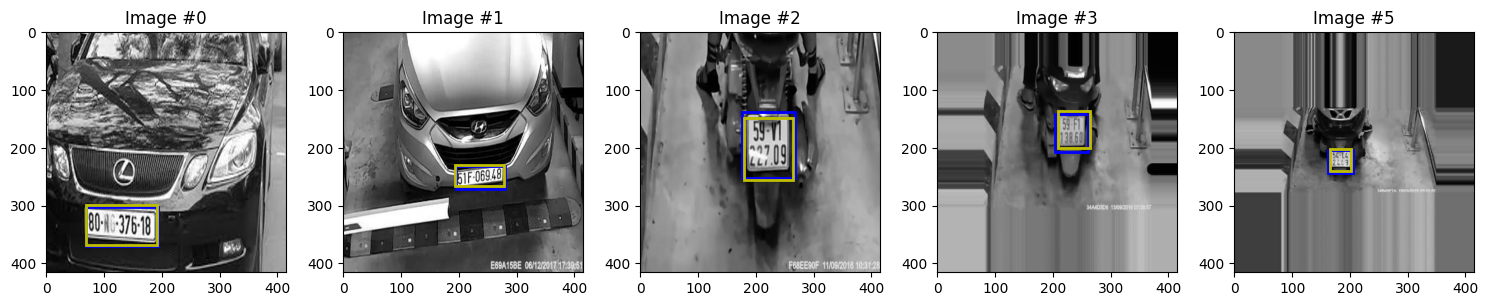

In [6]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

correct = 0
total = 0

ACCEPTABLE_DISTANCE = 15

correct_data = []
og_correctdata = []

net.eval()
def close_enough(num1, num2):
    a = num1
    b = num2
    return (abs(a - b) < ACCEPTABLE_DISTANCE)

demo_arr = []

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
       # real_bbox = torch.argmax(test_y[i])
        real_bbox = test_y[i]
        net_out = net(test_X[i].to(device).view(-1, 1, 416, 416))[0]
        #print(net_out)
        #predicted_bbox = torch.argmax(net_out)
        predicted_bbox = net_out
        #print(predicted_bbox[0], real_bbox[0])
        # print("Comparing", predicted_bbox, "with", real_bbox, "- Result: ", end="")
                    

        if close_enough(predicted_bbox[0], real_bbox[0]) and close_enough(predicted_bbox[1], real_bbox[1]) and close_enough(predicted_bbox[2], real_bbox[2]) and close_enough(predicted_bbox[3], real_bbox[3]):
            correct+= 1
            if len(demo_arr) < 5:
                demo_arr.append(["Image #{}".format(i), test_X[i].view(-1, 1, 416, 416), real_bbox, predicted_bbox])
                print(test_y[i].shape, test_X[i].shape)

            correct_data.append([np.asarray(test_y[i].cpu()), predicted_bbox.cpu()])
            og_correctdata.append([np.asarray(test_y[i].cpu()), real_bbox.cpu()])
            # print("Success!")
        # else:
            # print("Fail.")
        total += 1
        #print(real_bbox, net_out)

accuracy = round((correct / total) * 100, 3)
print("Accuracy:", accuracy, "%")
show_imgs(demo_arr)

torch.cuda.empty_cache()


In [7]:
# Save le model

import torch

def save_model(model, network_name, batch_size, epochs, learning_rate, accuracy):
    """
    Save the PyTorch model with a filename constructed from training parameters.

    Parameters:
    - model: The PyTorch model to save
    - network_name: Name of the neural network architecture (e.g., "ResNet50")
    - batch_size: Batch size used during training
    - epochs: Number of epochs for training
    - learning_rate: Learning rate used during training
    - accuracy: Final accuracy of the model

    Returns:
    - filename: The path to the saved model
    """
    # Construct the filename
    filename = f"{network_name}_B{batch_size}_E{epochs}_LR{learning_rate:.4f}_Acc{accuracy:.2f}.pth"
    
    # Save the model
    torch.save(model.state_dict(), os.path.join("models/checkpoints/", filename))
    
    return filename

print("Saved as:")
save_model(net, net.__class__.__name__, BATCH_SIZE, final_epoch + 1, LEARNING_RATE, accuracy)

Saved as:


'LPLocalNet_B250_E499_LR0.0010_Acc78.84.pth'